# Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
import re
import dateutil.parser as dp
import datetime as dt
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


imdb_df = pd.read_csv('imdb_info_9.csv')
mojo_df = pd.read_csv('mojo_info_3.csv')
imdb_single_page_df = pd.read_csv('single_page_imdb_info_4.csv')
numbers_df = pd.read_csv('numbers_info_4.csv')
inflation_df = pd.read_csv('inflation_data_fix.csv')
%matplotlib inline

/Users/karlrudeen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
imdb_df.columns

Index([u'director', u'rating', u'link', u'stars', u'title',
       u'description_runtime', u'year', u'rank'],
      dtype='object')

In [3]:
mojo_df.columns

Index([u'adjusted_opening', u'title', u'percent_of_total',
       u'average_per_theater', u'theaters', u'date', u'adjusted_gross'],
      dtype='object')

In [4]:
imdb_single_page_df.columns

Index([u'release_date', u'budget', u'metascore', u'title'], dtype='object')

In [5]:
numbers_df.columns

Index([u'domestic_gross(numbers)', u'title', u'release_date', u'rank',
       u'worldwide_gross(numbers)', u'production_budget'],
      dtype='object')

In [6]:
inflation_df.head()

,CPI_index,year
0,NaN,Annual
1,NaN,Year
2,9.8,1913
3,10.0,1914
4,10.1,1915


In [7]:
def get_year(date):
    try:
        date_time= dp.parse(date)
        return int(date_time.year)
    except:
        return np.nan
    

I have a lot of dataframes that need to be merged! It is not enough to merge on title only because there are multiple movies with the same name. Therefore, we merge on title and year of release. This seems to be enough to avoid duplication errors.

In [8]:
imdb_single_page_df['year'] = imdb_single_page_df['release_date'].apply(get_year)

mojo_df['year'] = mojo_df['date'].apply(get_year)

imdb_df['year'] = imdb_df['year'].apply(get_year)

numbers_df['year'] = numbers_df['release_date'].apply(get_year)

imdb_single_page_df['title'] = imdb_single_page_df['title'].apply(lambda x : x[:x.find('\xc2\xa0')])

df_total = pd.merge(mojo_df, imdb_df, on = ['title', 'year'])

df_total_3 = pd.merge(imdb_single_page_df, df_total, on=['title','year'])

df_total_4 = pd.merge(df_total_3, numbers_df, on = ['title', 'year'])


Time to take a look at my new dataframe.


In [9]:
df_total_4.head()

,release_date_x,budget,metascore,title,year,adjusted_opening,percent_of_total,average_per_theater,theaters,date,...,rating,link,stars,description_runtime,rank_x,domestic_gross(numbers),release_date_y,rank_y,worldwide_gross(numbers),production_budget
0,14 October 1994,"25,000,000",80.0,The Shawshank Redemption,1994.0,"$4,948,800",8.6%,"$5,242",944,10/14/1994,...,9.3,/title/tt0111161/,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...","<div class=""item_description"">Two imprisoned m...",3.0,"$28,241,469",9/23/1994,2029,"$28,307,092","$25,000,000"
1,3 July 1985,"19,000,000",86.0,Back to the Future,1985.0,"$27,048,700",5.3%,"$19,046","1,420",7/3/1985,...,8.5,/title/tt0088763/,"Michael J. Fox,Christopher Lloyd,Lea Thompson,...","<div class=""item_description"">Marty McFly, a 1...",5.0,"$212,259,762",7/3/1985,2467,"$385,524,862","$19,000,000"
2,14 October 1994,"8,000,000",94.0,Pulp Fiction,1994.0,"$19,180,700",8.8%,"$14,334","1,338",10/14/1994,...,8.9,/title/tt0110912/,"John Travolta,Uma Thurman,Samuel L. Jackson,Br...","<div class=""item_description"">The lives of two...",1.0,"$107,928,762",10/14/1994,3514,"$212,928,762","$8,000,000"
3,2 May 2014,"200,000,000",53.0,The Amazing Spider-Man 2,2014.0,"$94,687,600",45.1%,"$21,898","4,324",5/2/2014,...,6.7,/title/tt1872181/,"Andrew Garfield,Emma Stone,Jamie Foxx,Paul Gia...","<div class=""item_description"">When New York is...",2.0,"$202,853,933",5/2/2014,45,"$708,996,336","$200,000,000"
4,24 June 1994,"45,000,000",83.0,The Lion King,1994.0,"$84,221,900",13.1%,"$33,002","2,552",6/24/1994,...,8.5,/title/tt0110357/,"Matthew Broderick,Jeremy Irons,James Earl Jone...","<div class=""item_description"">Lion cub and fut...",10.0,"$422,780,140",6/15/1994,535,"$987,480,140","$79,300,000"


In [10]:
df_total_4.columns

Index([u'release_date_x', u'budget', u'metascore', u'title', u'year',
       u'adjusted_opening', u'percent_of_total', u'average_per_theater',
       u'theaters', u'date', u'adjusted_gross', u'director', u'rating',
       u'link', u'stars', u'description_runtime', u'rank_x',
       u'domestic_gross(numbers)', u'release_date_y', u'rank_y',
       u'worldwide_gross(numbers)', u'production_budget'],
      dtype='object')

In [11]:
df_total_4 = df_total_4.drop(['description_runtime', 'release_date_x', 'budget', 'worldwide_gross(numbers)', 'rank_x', 'rank_y'], axis = 1)

This dataframe is a mess. Not to worry, it will be clean soon!

In [12]:
min(df_total_4['year'])

1982.0

My data is mostly in string format. I want ints and floats, so I will write some functions and apply them to fix up the dataframe.

In [13]:
def string_to_int(x):
    try:
        reg_exp = re.compile(r'[^\d.]+')
        return int(reg_exp.sub('',x))
    except:
        return np.nan

In [14]:
def string_to_float(x):
    try:
        reg_exp = re.compile(r'[^\d.]+')
        return float(reg_exp.sub('',x))
    except:
        return np.nan

In [15]:
def make_star_list(x):
    try:
        return x.split(',')
    except:
        return x

The director data is full of unicode characters. We manually correct that here.

In [16]:
def format_director_strings(x):
    try:
        return x.replace('\xc3', '').replace('\xa1', 'a').replace('\xb3', 'o').replace('\xb1', 'n').replace('\xb6', 'o').replace('\xa9','e').replace('\xa5','a').replace('\xb6','o')    
    except: 
        return np.nan

In [17]:
inflation_df.head()

,CPI_index,year
0,NaN,Annual
1,NaN,Year
2,9.8,1913
3,10.0,1914
4,10.1,1915


In [18]:
df_total_4['adjusted_gross'] = df_total_4['adjusted_gross'].apply(string_to_int)
df_total_4['average_per_theater'] = df_total_4['average_per_theater'].apply(string_to_int)
df_total_4['theaters'] = df_total_4['theaters'].apply(string_to_int)
df_total_4['adjusted_opening'] = df_total_4['adjusted_opening'].apply(string_to_int)
df_total_4['percent_of_total'] = df_total_4['percent_of_total'].apply(string_to_float)
df_total_4['rating'] = df_total_4['rating'].apply(string_to_float)
df_total_4['stars_list'] = df_total_4['stars'].apply(make_star_list)
df_total_4['production_budget'] = df_total_4['production_budget'].apply(string_to_int)
df_total_4['director'] = df_total_4['director'].apply(format_director_strings)

Unlike our other money related variables, production budget has not been adjusted for inflation, so we adjust here:

In [20]:
inflation_df = inflation_df.dropna()

inflation_df['year'] = inflation_df['year'].apply(string_to_int)

inflation_df['CPI_index'] = inflation_df['CPI_index'].apply(string_to_float).dropna()

In [21]:
df_total_4 = pd.merge(inflation_df,df_total_4, on='year')

In [ ]:
def adjusted (x,y):
    return (x*y)

In [22]:
df_total_4['adjusted_budget'] = np.vectorize(adjusted)(df_total_4['production_budget'],df_total_4['CPI_index'])

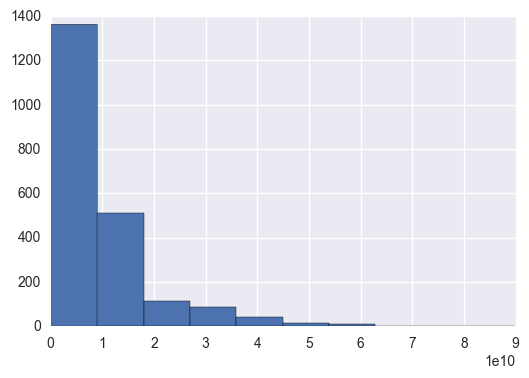

In [28]:
plt.hist(df_total_4['adjusted_budget']);

This is not normally distributed. We take the log to fix it.

In [23]:
df_total_4['log_adjusted_budget'] = df_total_4['adjusted_budget'].apply(np.log)

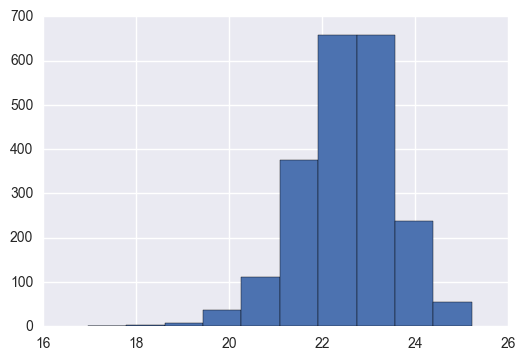

In [29]:
plt.hist(df_total_4['log_adjusted_budget']);

This looks much better.

In [33]:
df_total_4['log_adjusted_gross'] = df_total_4['adjusted_gross'].apply(np.log)
df_total_4['log_average_per_theater'] = df_total_4['average_per_theater'].apply(np.log)

df_total_4['average_per_theater_2'] = df_total_4['average_per_theater'] **2
df_total_4['average_per_theater_3'] = df_total_4['average_per_theater'] **3
df_total_4['average_per_theater_4'] = df_total_4['average_per_theater'] **4

# COMMENCE REGRESSION ANALYSIS

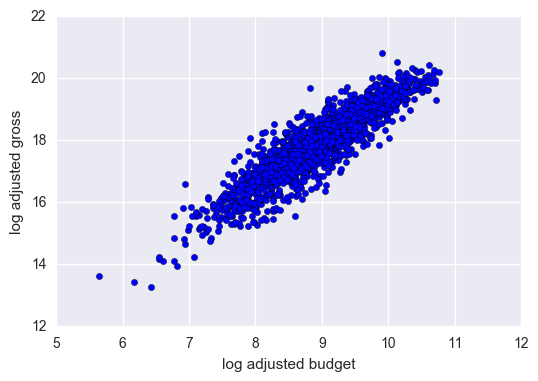

In [34]:
plt.scatter(df_total_4['log_average_per_theater'], df_total_4['log_adjusted_gross'])
plt.xlabel('log average per theater')
plt.ylabel('log adjusted gross')

In [25]:
df_total_4.corr()

,CPI_index,year,metascore,adjusted_opening,percent_of_total,average_per_theater,theaters,adjusted_gross,rating,production_budget,adjusted_budget,log_adjusted_budget,log_adjusted_gross,average_per_theater_2,average_per_theater_3,average_per_theater_4
CPI_index,1.000000,0.997493,-0.044419,0.074814,0.358336,-0.226474,0.505985,-0.150780,-0.042404,0.270270,0.377614,0.404596,-0.146002,-0.149219,-0.084674,-0.043247
year,0.997493,1.000000,-0.051348,0.076758,0.362367,-0.228420,0.511750,-0.152651,-0.046995,0.272940,0.379326,0.408447,-0.146459,-0.150701,-0.085356,-0.043344
metascore,-0.044419,-0.051348,1.000000,0.243338,-0.515093,0.330575,-0.033992,0.375555,0.758930,0.170229,0.158099,0.134676,0.397330,0.264184,0.204857,0.163996
adjusted_opening,0.074814,0.076758,0.243338,1.000000,-0.118933,0.891873,0.604115,0.816454,0.235940,0.633731,0.607291,0.503691,0.737768,0.871727,0.789636,0.705068
percent_of_total,0.358336,0.362367,-0.515093,-0.118933,1.000000,-0.328191,0.149946,-0.465767,-0.487550,-0.041418,0.005049,-0.005063,-0.601438,-0.202612,-0.113940,-0.062011
average_per_theater,-0.226474,-0.228420,0.330575,0.891873,-0.328191,1.000000,0.298752,0.869339,0.321482,0.441663,0.389455,0.287182,0.806420,0.934760,0.815409,0.707315
theaters,0.505985,0.511750,-0.033992,0.604115,0.149946,0.298752,1.000000,0.365703,-0.021979,0.628832,0.648561,0.700535,0.491924,0.261169,0.222641,0.192360
adjusted_gross,-0.150780,-0.152651,0.375555,0.816454,-0.465767,0.869339,0.365703,1.000000,0.371279,0.489186,0.437652,0.355356,0.818379,0.813232,0.700101,0.596032
rating,-0.042404,-0.046995,0.758930,0.235940,-0.487550,0.321482,-0.021979,0.371279,1.000000,0.169925,0.162765,0.129494,0.387798,0.260941,0.203921,0.162748
production_budget,0.270270,0.272940,0.170229,0.633731,-0.041418,0.441663,0.628832,0.489186,0.169925,1.000000,0.985477,0.838088,0.481152,0.403419,0.347419,0.300317


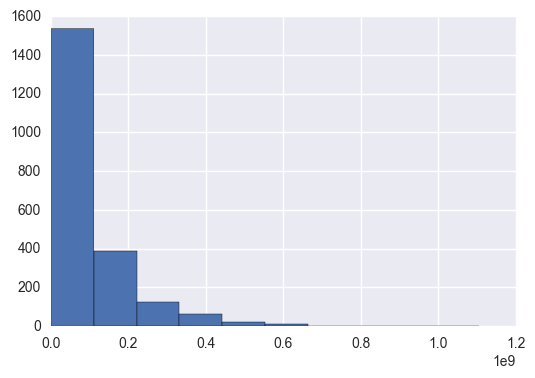

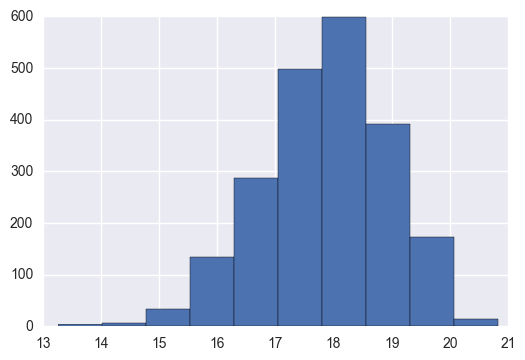

In [27]:
plt.hist(df_total_4['log_adjusted_gross']);

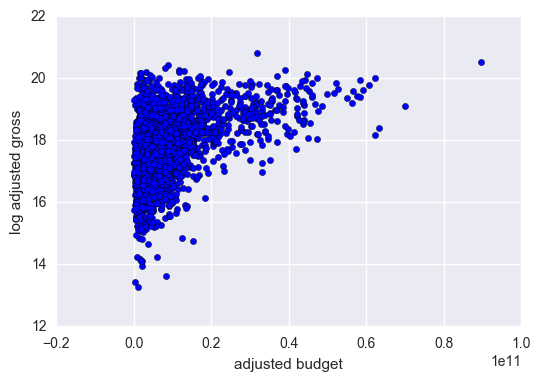

In [35]:
plt.scatter(df_total_4['adjusted_budget'], df_total_4['log_adjusted_gross'])
plt.xlabel('adjusted budget')
plt.ylabel('log adjusted gross')

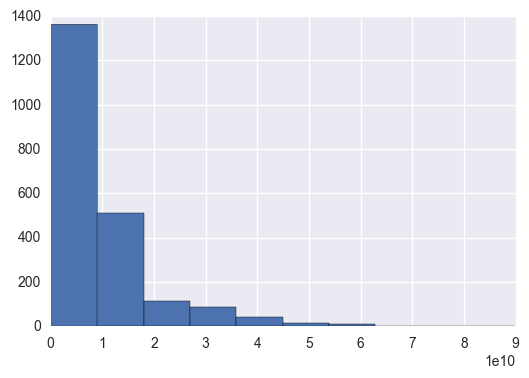

In [36]:
plt.hist(df_total_4['adjusted_budget']);

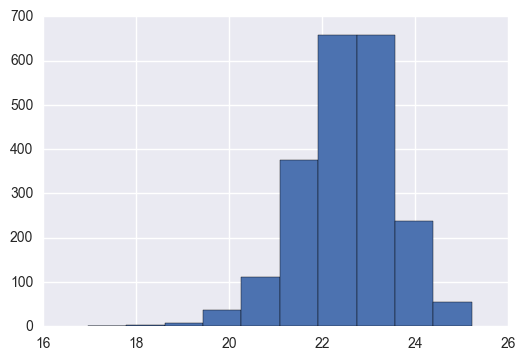

In [37]:
plt.hist(df_total_4['log_adjusted_budget']);

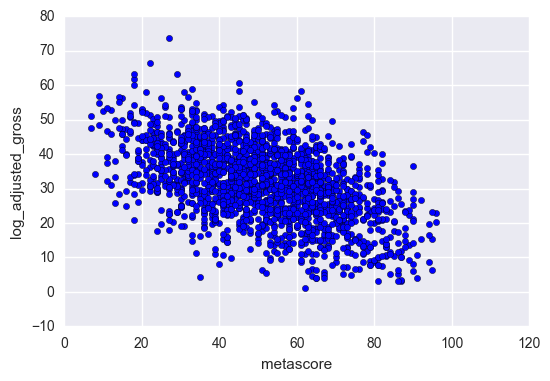

In [49]:
plt.scatter(df_total_4['metascore'], df_total_4['percent_of_total'])
plt.xlabel('metascore')
plt.ylabel('log_adjusted_gross')

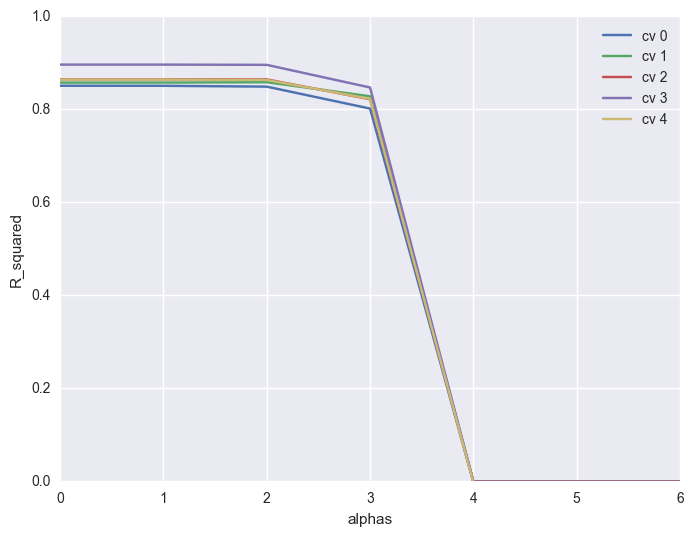

In [50]:
all_scores=[]
alphas=[1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
df_total_4 = df_total_4.dropna()
actors = df_total_4['stars'].str.get_dummies(sep=',') #srt
#genres = bb_df_full['genre'].str.get_dummies(sep=',')
y,X = patsy.dmatrices('log_adjusted_gross ~ metascore + log_adjusted_budget +\
                      log_average_per_theater',\
                      data = df_total_4, return_type = 'dataframe')

X_new = X#np.concatenate([X, actors.as_matrix()], axis = 1)

X_sc=preprocessing.normalize(X_new, axis=0, norm='max')

kf = KFold(n=len(X_sc), n_folds=5, shuffle=True)

#print(X_sc)
train_scores = []
for train, test, in kf:
    x_train=X_sc[train]
    y_train=y.iloc[train]
    x_test=X_sc[test]
    y_test=y.iloc[test]
    r_squared_score = []
    train_score = []
    
    for a in alphas:
        est = Lasso(alpha=a)
        est.fit(x_train, y_train)
        #mse = np.mean((y_test.as_matrix()-est.predict(x_test))**2)
        r_squared_score.append(est.score(x_test,y_test))
        train_score.append(est.score(x_train, y_train))
        #mse_score.append(mse)
    all_scores.append(r_squared_score)
    train_scores.append(train_score)

plt.figure(figsize=(8,6))
plt.ylim(0,1)
#plt.ylim(0,24167633424134260.0)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('R_squared')
plt.show()

In [51]:
df_total_4 = df_total_4.dropna()
actors = df_total_4['stars'].str.get_dummies(sep=',') #srt

y,X = patsy.dmatrices('log_adjusted_gross ~ metascore + log_adjusted_budget +\
                      log_average_per_theater',\
                      data = df_total_4, return_type = 'dataframe')

X_new = np.concatenate([X, actors.as_matrix()], axis = 1)
X_sc=preprocessing.normalize(X_new, axis=0, norm='max')
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.2)

est=Lasso(alpha=1e-3)
est.fit(X_train,y_train)
est.alpha

zipped=zip(X.columns, est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features[:10]



[('log_average_per_theater', 13.261289229021269),
 ('log_adjusted_budget', 4.0964834870847584),
 ('metascore', 0.47927786524377602),
 ('Intercept', 0.0)]